In [1]:
%matplotlib inline
from utils import *
from pycaret.regression import*

from sklearn.metrics import mean_squared_error

In [2]:
class DATA(object):
    
    def __init__(self, dataset_name, target, features):
        
        self.features_list = list()
        self.target_list = list()
        
        folder_path = os.path.dirname( get_dataset_file_path(dataset_name,'') )
        for file_path in list(Path(folder_path).glob('*.pkl')):        
            data = pd.read_pickle( file_path )             
            features_df = data.filter(regex=features, axis=1)
            target_df = data.filter(regex=target, axis=1).rename({target:'target'}, axis=1)
            
            self.features_list.append( features_df )
            self.target_list.append( target_df)                
        return
     
    
    
    def get_data(self, idxs_list=None, win_size=None, step=None):        
        if idxs_list is None: idxs_list = np.arange(len(self.features_list))  
        if win_size is not None:
            if step is None: step = win_size
#             elif type(step) is float: step = max(1, int(step * win_size))

        dataset_df = pd.DataFrame()     
        for idx in idxs_list:  
            features_df, target_df = self.features_list[idx], self.target_list[idx]
            if win_size is not None: features_df, target_df = segment(features_df, target_df, win_size, step)
            
            dataset_df = dataset_df.append( pd.concat([ target_df, features_df], axis=1), ignore_index=True )
        dataset_df.astype('float64').dtypes
        return dataset_df
 

  
def segment(features_df, target_df, win_size, step):
    
    features_df_segmented = pd.DataFrame()
    target_df_segmented = pd.DataFrame()

    for i in range(0, len(features_df)- win_size, step):
        target_df_segmented = target_df_segmented.append(target_df.loc[i+win_size-1], ignore_index=True)

        row = dict()
        for feature_name in features_df.columns: 
            for j in range(win_size): row.update({ feature_name + "{0:0=2d}".format(j): features_df.loc[i+j, feature_name] })        
        features_df_segmented = features_df_segmented.append(row, ignore_index=True)

    return features_df_segmented, target_df_segmented

#### Load Data

In [3]:
data = DATA( 
    dataset_name = 'dataset_02',
    target = 'distance_1',
    features = 'rssi'
)

# Regression

#### Sliding Window

In [4]:
win_size = 20
step = 5

train_data = data.get_data(idxs_list=np.arange(5,30), win_size=win_size, step=step)

#### Setup

In [31]:
exp_reg = setup(train_data,
                train_size = .8,
                target = 'target', 
#                 normalize = True, 
                silent = True,
                session_id = 20
                )   

 
Setup Succesfully Completed!


,Description,Value
0,session_id,20
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(2438, 41)"
4,Missing Values,False
5,Numeric Features,40
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


#### Model

In [29]:
model = tune_model('gbr')
# model = create_model('rf')

# print(round(exp_reg[-1][-1][-1].RMSE.Mean / np.mean(exp_reg[-1][2][-1]) * 100, 2))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0783,0.0096,0.0980,-0.2409,0.0737,0.2691
1,0.0746,0.0087,0.0930,-0.2959,0.0709,0.2814
2,0.0643,0.0068,0.0822,-0.1836,0.0623,0.2211
3,0.0810,0.0101,0.1006,-0.2223,0.0763,0.2943
4,0.0837,0.0102,0.1008,-0.3221,0.0760,0.2868
5,0.0709,0.0080,0.0895,-0.1996,0.0672,0.2306
6,0.0639,0.0065,0.0808,-0.1711,0.0613,0.2172
7,0.0720,0.0081,0.0902,-0.3841,0.0681,0.2507
8,0.0711,0.0080,0.0896,-0.3479,0.0677,0.2402
9,0.0731,0.0083,0.0912,-0.2073,0.0686,0.2442


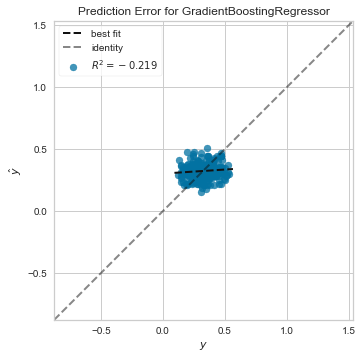

In [30]:
plot_model(model, plot='error')
# plot_model(model, plot='feature')

#### Validation

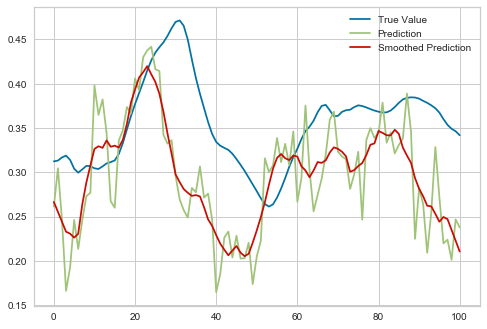

In [27]:
test_data = data.get_data( idxs_list=[0], win_size=win_size, step=step)
prediction = predict_model(model, data=test_data)
smoothed_pred = signal.savgol_filter( prediction.Label, window_length=7, polyorder=1)  

ax = prediction.plot(y='target', legend=False)
prediction.plot(y='Label', ax=ax)
plt.plot(smoothed_pred)
plt.legend(['True Value', 'Prediction', 'Smoothed Prediction'])
plt.show()

In [ ]:
# save_experiment(get_result_file_path('res_00'))

In [38]:
# compare_models()

In [4]:
filepath = get_result_file_path('/'+'gbr'+'/' + str(10) + '_' + str(15) )
filepath

'C:\\Users\\mixil\\Desktop\\MIHAR_Hardware\\experiments/results//gbr/10_15'

# Grid Search

In [6]:
def grid_search( data, model_name, win_size_range, step_range ):
    for win_size in win_size_range:
        for step in step_range:
            if type(step) is float: step = max(1, int(step*win_size))
            if step is None: step = win_size
                
            filepath = get_result_file_path('/'+model_name+'/' + str(win_size) + '_' + str(step) )
            if os.path.isfile(filepath + '.pkl'): continue
            try:
                train_data = data.get_data(idxs_list=np.arange(5,30), win_size=win_size, step=step)
                exp_reg = setup(train_data,
                                train_size = .8,
                                target = 'target', 
                                session_id = 20,
                                silent = True
                                )
                model = tune_model(model_name)
                save_model(model, filepath)
            except:
                continue    
    return

In [ ]:
grid_search( data, 
            'gbr', 
            win_size_range = np.arange(1,20), 
            step_range =  [.2, .5, .75, None] )

# Comparison

In [48]:
def evaluate_saved_models( data, model_name, win_size, step, smoothing_win_size_range=np.arange(15) ):
    if type(step) is float: step = max(1, int(step*win_size))
    if step is None: step = win_size    
    
    smoothing_win_size_range = smoothing_win_size_range[smoothing_win_size_range>1]
    smoothing_win_size_range = smoothing_win_size_range[ (smoothing_win_size_range%2) == 1]

    filepath = get_result_file_path('/'+model_name+'/' + str(win_size) + '_' + str(step) )
    if os.path.isfile(filepath + '.pkl'): 
        test_data = data.get_data(idxs_list=[0], win_size=win_size, step=step)        
        model = load_model(filepath)
        prediction = predict_model(model, data=test_data)
        target = prediction.target.to_numpy()
        pred = prediction.Label.to_numpy()
        rmse =  mean_squared_error( target, pred )

        results = list()
        for smoothing_win_size in smoothing_win_size_range:
            smoothed_pred = signal.savgol_filter( pred, window_length=smoothing_win_size, polyorder=1)   
            smoothed_rmse =  mean_squared_error( target, smoothed_pred ) 
            results.append((smoothed_rmse, smoothed_pred, smoothing_win_size))                
        
        smoothed_rmse, smoothed_pred, smoothing_win_size = sorted(results, key=lambda x: x[0])[0]
        
        return rmse, smoothed_rmse, target, pred, smoothed_pred, win_size, step, smoothing_win_size
    
    return None

In [49]:
model_name = 'gbr'

results = list()
for win_size in range(10):
    for step in [.2, .5, .75, None]:
        best_result = evaluate_saved_models( data, model_name, win_size, step, smoothing_win_size_range=np.arange(15) )
        if best_result is not None:
            results.append(best_result)                

NRMSE= 14.4


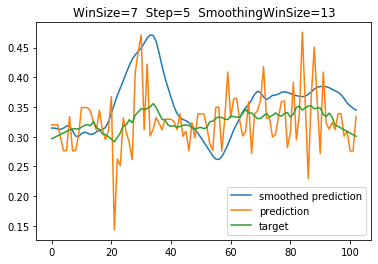

NRMSE= 15.37


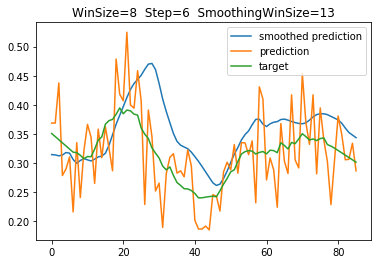

NRMSE= 16.03


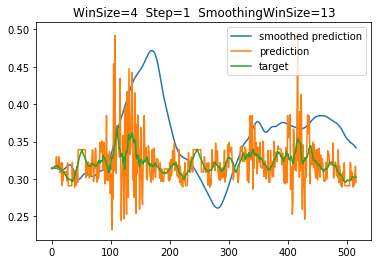

NRMSE= 16.27


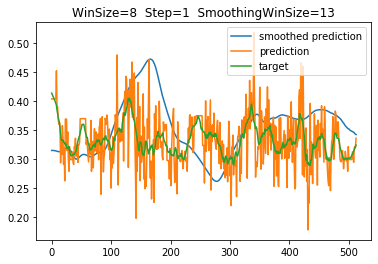

NRMSE= 16.33


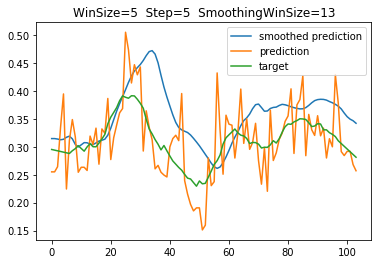

In [50]:
best_results = sorted(results, key=lambda x: x[1])

for res in best_results[:5]:
    rmse, smoothed_rmse, target, pred, smoothed_pred, win_size, step, smoothing_win = res

    plt.plot(target)
    plt.plot(pred)
    plt.plot(smoothed_pred)
    plt.legend({'target','prediction','smoothed prediction'})
    plt.title( 'WinSize='+str(win_size) + '  Step='+str(step) + '  SmoothingWinSize='+str(smoothing_win) )
    print( 'NRMSE=', round(smoothed_rmse**0.5 / np.mean(target) *100, 2) )
    plt.show()            

# sklearn

In [ ]:
from sklearn import*
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingRegressor
>>> reg = GradientBoostingRegressor(random_state=0)
>>> reg.fit(X_train, y_train)
GradientBoostingRegressor(random_state=0)
>>> reg.predict(X_test[1:2])
array([-61...])
>>> reg.score(X_test, y_test)


In [50]:
X_train = data.filter(regex='rssi', axis=1).to_numpy()
Y_train = data.filter(regex='target', axis=1).to_numpy()

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)



Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

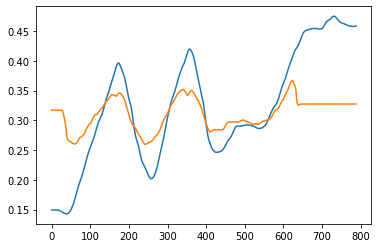

In [55]:
data_unseen = get_data( dataset_name, [29], target, features, win_size=win_size, step_size_ratio=step_size_ratio )

X_validation = data_unseen.filter(regex='rssi', axis=1).to_numpy()
Y_validation = data_unseen.filter(regex='target', axis=1).to_numpy()

predictions = model.predict( X_validation )  

plt.plot(Y_validation)
plt.plot(predictions)
plt.show()